# _De novo_ Reinforcement Learning with the Reinvent prior

This is a short demo to
- Set up a reinforcement  learning run
- Carry out a reinforcement  learning run
- Visualize the results with TensorBoard
- Extract the raw data from TensorBoard and how to work with it

In [1]:
import os
import shutil

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import reinvent
from reinvent.notebooks import load_tb_data, plot_scalars, get_image, create_mol_grid

%load_ext tensorboard

## Set up the REINVENT run

A work directory is defined and created anew (all previous data deleted if the directory already exists).  The prior file is taken from the REINVENT repository and the agent is initially the same as the prior.  A TOML configuration is written out to file in the work directory.

In [2]:
wd = "/tmp/R4_notebooks_output"

### Delete existing working directory (!)

Skip this step if you have already carried out the RL run but wish to analyse the results further.

In [ ]:
shutil.rmtree(wd, ignore_errors=True)
os.mkdir(wd)
os.chdir(wd)

### Global configuration parameters

Parameters global to the run:
- The run type: one of "scoring", "sampling", "transfer_learning", and "staged_learning"
- The device to run on: "cpu" or "cuda:0" where the number is the device index (needed for ROCm)
- The output directory for TensorBoard (optional)
- The configuration file in JSON format (optional)

In [12]:
global_parameters = """
run_type = "staged_learning"
device = "cuda:0"
tb_logdir = "tb_stage1"
json_out_config = "_stage1.json"
"""

### Parameters

Here we specify the model files, the prefix for the output CSV summary file and the batch size for sampling and stochastic gradient descent (SGD).  The batch size is often given in 2^N but there is in now way required.  Typically batch sizes are between 50 and 150.  Batch size effects on SGD and so also the learning rate.  Some experimentation may be required to adjust this but keep in mind that, say, raising the total score as fast as possible is not necessarily the best choice as this may hamper exploration.

In [13]:
prior_filename = os.path.join(reinvent.__path__[0], "..", "priors", "reinvent.prior")
agent_filename = prior_filename

parameters = f"""
[parameters]

prior_file = "{prior_filename}"
agent_file = "{agent_filename}"
summary_csv_prefix = "stage1"

batch_size = 100

use_checkpoint = false
"""

### Reinforcement Learning strategy

In [14]:
learning_strategy = """
[learning_strategy]

type = "dap"
sigma = 128
rate = 0.0001
"""

###  Stage setup

Here we only use a single stage. The aim of this stage is to create an agent which is highly likely to generate "drug-like" molecules (as per QED and Custom Alerts) with no stereocentres

The stage will terminate when a maximum number of 300 steps is reached.  Termination could occur earlier when the maximum score of 1.0 is exceeded but this is very unlikely to occur.  A checkpoint file is written out which can be used as the agent in a subsequent stage.

The scoring function is a weighted product of all the scoring components: QED and number of sterecentres.  The latter is used here to avoid stereocentres as they are not supported by the Reinvent prior.  Zero stereocentres aids in downstream 3D task to avoid having to carry out stereocentre enumeration.  Custom alerts is a filter which filters out (scores as zero) all generated compounds which match one of the SMARTS patterns.  Number of sterecentres uses a transformation function to ensure the component score is between 0 and 1.

In [15]:
stages = """
[[stage]]

max_score = 1.0
max_steps = 300

chkpt_file = 'stage1.chkpt'

[stage.scoring]
type = "geometric_mean"

[[stage.scoring.component]]
[stage.scoring.component.custom_alerts]

[[stage.scoring.component.custom_alerts.endpoint]]
name = "Alerts"

params.smarts = [
    "[*;r8]",
    "[*;r9]",
    "[*;r10]",
    "[*;r11]",
    "[*;r12]",
    "[*;r13]",
    "[*;r14]",
    "[*;r15]",
    "[*;r16]",
    "[*;r17]",
    "[#8][#8]",
    "[#6;+]",
    "[#16][#16]",
    "[#7;!n][S;!$(S(=O)=O)]",
    "[#7;!n][#7;!n]",
    "C#C",
    "C(=[O,S])[O,S]",
    "[#7;!n][C;!$(C(=[O,N])[N,O])][#16;!s]",
    "[#7;!n][C;!$(C(=[O,N])[N,O])][#7;!n]",
    "[#7;!n][C;!$(C(=[O,N])[N,O])][#8;!o]",
    "[#8;!o][C;!$(C(=[O,N])[N,O])][#16;!s]",
    "[#8;!o][C;!$(C(=[O,N])[N,O])][#8;!o]",
    "[#16;!s][C;!$(C(=[O,N])[N,O])][#16;!s]"
]

[[stage.scoring.component]]
[stage.scoring.component.QED]

[[stage.scoring.component.QED.endpoint]]
name = "QED"
weight = 0.6


[[stage.scoring.component]]
[stage.scoring.component.NumAtomStereoCenters]

[[stage.scoring.component.NumAtomStereoCenters.endpoint]]
name = "Stereo"
weight = 0.4

transform.type = "left_step"
transform.low = 0
"""

In [16]:
config = global_parameters + parameters + learning_strategy + stages

toml_config_filename = "stage1.toml"

with open(toml_config_filename, "w") as tf:
    tf.write(config)

##  Start Reinforcement Learning

This run will take several minutes to finish and timings are provided at the end of the run.  After the run the TensorBoard output can be used to inspect the results of the run

In [18]:
%%time
!reinvent -l stage1.log $toml_config_filename

CPU times: total: 172 ms
Wall time: 2min 21s


### Inspect results with TensorBoard

TensorBoard needs to be started after REINVENT has finished.  Scatter plots of all scoring components are shown (raw and transformed) in the _SCALARS_ tab as well as loss and fractions of valid and duplicate (per batch) SMILES.  The _IMAGES_ tab shows the first sampled molecules for each recorded RL step labelled with the total score for the molecule.

The loss likelihoods (negative log likelihoods, NLL) for the agent is expected to move away from the prior NLL and also have smaller NLLs than the prior.  This shows that the agent is increasingly producing molecules different from the prior, closer to the signal from the scoring function as requested.  For sample efficiency it is desirable to observed few duplicates and a high number of valid molecules.  Note that results are stochastic and will not be different in every run of RL, even with exactly the same configuration.

In [22]:
%tensorboard --bind_all --logdir $wd/tb_stage1_0

Reusing TensorBoard on port 6006 (pid 27300), started 0:01:53 ago. (Use '!kill 27300' to kill it.)

## Extract data from TensorBoard

TensorBoard data can be directly extracted as shown in this section.

### Load the TB data

In [20]:
ea = load_tb_data(wd)

### Plot all scalars

All scalar values (except the raw components) are plotted here.  The data is also return as a Pandas dataframe and can so be conveniently used for further analysis or storing to a file.

In [21]:
df = plot_scalars(ea)

AttributeError: 'NoneType' object has no attribute 'Tags'

In [ ]:
df

### Display an image from TB

Shows (only) the last image from TB.  The image depicts the first 30 molecules generated in the very last step of RL:

In [ ]:
img = get_image(ea)
display(img)

## Extract data from the CSV file

The CSV file is generated during the RL run in real time i.e. as soon as the data is available it is written to file. So even if the RL job crashes in the middle of the run some partial data will be available.  The TensorBoard data is a subset of the data in the CSV file.  The CSV file contains in addition all SMILES strings, their state (0=invalid, 1=valid, 2=batch duplicate), the scaffold if a diversity filter has been used.

In [24]:
csv_file = r"C:\Users\andre\OneDrive\Desktop\REINVENT4\notebooks\stage1_1.csv"
df = pd.read_csv(csv_file)
df

,Agent,Prior,Target,Score,SMILES,SMILES_state,QED,QED (raw),Stereo,Stereo (raw),Alerts,Alerts (raw),step
0,37.4505,37.4505,-37.4505,0.000000,c1n2c(=O)c3c(nc2ccc1)cc1c2c(nc(CN4CCOCC4)c1-3)...,0,0.000000,0.0000,0.0,0.0,0.0,0.0,1
1,25.4351,25.4351,-25.3640,0.000555,Cn1nccc1CN1CC2CN(C(=O)C3CCOC3)CC2C1,1,0.808308,0.8083,0.0,3.0,1.0,1.0,1
2,29.5261,29.5261,-29.5261,0.000000,COc1cc(OC)nc(COC(=O)c2ccc(Br)cc2O)n1,1,0.000000,0.0000,0.0,0.0,0.0,0.0,1
3,28.9582,28.9582,50.7426,0.622663,COc1cccc(-c2cc(NC(N)=O)cc(-c3ccc4cc(OC)ccc4c3)...,1,0.454034,0.4540,1.0,0.0,1.0,1.0,1
4,21.0865,21.0865,84.8263,0.827444,Oc1c(C(F)(F)F)ccc2cccnc12,1,0.729285,0.7293,1.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,15.4735,21.5352,85.1454,0.833442,CN(C)c1ccc(-c2ccccn2)nn1,1,0.738118,0.7381,1.0,0.0,1.0,1.0,300
29996,18.7309,21.0925,86.7186,0.842274,FC(F)(F)c1ccc(N=c2cc(-c3ccccc3)nc[nH]2)cc1,1,0.751201,0.7512,1.0,0.0,1.0,1.0,300
29997,17.3742,21.9383,76.5183,0.769192,N=c1[nH]c(=Nc2ccc(S(N)(=O)=O)cc2)[nH]cc1C(F)(F)F,1,0.645741,0.6457,1.0,0.0,1.0,1.0,300
29998,14.3380,17.5602,92.2311,0.857744,CCCN1CCN(c2ccc(F)cc2)CC1,1,0.774336,0.7743,1.0,0.0,1.0,1.0,300


### Sample efficiency

Count the number of total invalid and duplicate SMILES and compare to the total number of generated SMILES.

In [25]:
total_smilies = len(df)

invalids = df[df["SMILES_state"] == 0]
total_invalid_smilies = len(invalids)

duplicates = df[df["SMILES_state"] == 2]
total_batch_duplicate_smilies = len(duplicates)

all_duplicates = df[df.duplicated(subset=["SMILES"])]
total_duplicate_smilies = len(all_duplicates)

print(
    f"Total number of SMILES generated: {total_smilies}\n"
    f"Total number of invalid SMILES generated: {total_invalid_smilies}\n"
    f"Total number of batch duplicate SMILES generated: {total_batch_duplicate_smilies}\n"
    f"Total number of duplicate SMILES generated: {total_duplicate_smilies}"
)

Total number of SMILES generated: 30000
Total number of invalid SMILES generated: 282
Total number of batch duplicate SMILES generated: 15
Total number of duplicate SMILES generated: 1561


### Display all generated duplicates

In [26]:
mol_view = create_mol_grid(all_duplicates)
display(mol_view)

MolGridWidget()

### Display the molecules from the last step

In [27]:
last = df[df["step"] == max(df["step"])]
mol_view = create_mol_grid(last)
display(mol_view)

MolGridWidget()

### Plot the NLLs

The "Target" is the "augmented NLL".

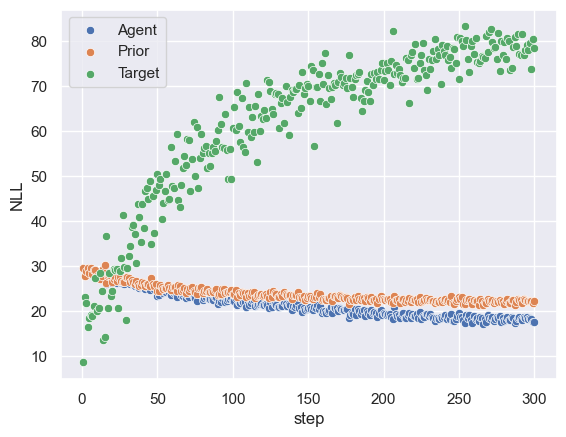

In [28]:
grouped_df = df.groupby("step")

for label in "Agent", "Prior", "Target":
    means = grouped_df.aggregate({label: "mean"})
    X = list(means.index.values)
    sns.scatterplot(means, x=X, y=label, label=label)

plt.xlabel("step")
plt.ylabel("NLL")
plt.show()